# Capstone Project Sandbox

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/ssrosa/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [66]:
class Lot(object):
    def __init__(self):
        self.size = None
        #Coords where lot is. Just for viz
        self.loc = []
        #Simplify model by making land worth $1 per sqft at start
        self.value = self.size
        self.owned_by = None

#    def value_increase(self, by):
        #Start with just inflation
        #self.value *= 1 + by

#Lot.value_increase = value_increase

class Household(object):
    def __init__(self):
        self.lot = None
        #Simplify model by holding can_spend constant
        self.can_spend = 0

def sell():
    pass
    
class Simulation(object):
    def __init__(self, total_time_steps, land, num_lots, lot_size_avg, lot_size_std,
                 pop_start, can_spend_avg, can_spend_std,
                 years):
        self.housing_stock = []
        self.current_time_step = 0
        self.total_time_steps = total_time_steps
        #self.land_log = [land]
        
        #Create population distribution to simulate variety of lot sizes
        #For now house size equals lot size
        lots = np.random.normal(scale = lot_size_std, loc = lot_size_avg, size = num_lots)
        
        #Fill up land area with lots
        while land > 0:
            size = np.round(np.random.choice(lots, replace = False), 0)
            #Create a new household only if the house/lot size will fit on the available land left
            if size > land:
                #Need to break the loop here otherwise it keeps running until a random size is
                #drawn that fits the available remaning land.
                break
            else:
                 #Instantiate a lot with a random size
                lot = Lot()
                lot.size = size
                #Simplify model by making land worth $1/sqft
                lot.value = size
                land -= size
                self.housing_stock.append(lot)

In [46]:
def draw_land_grid(land):
    '''Writes a dict of y values, each with a dict of x values.
    Works as a grid of xes and yes.'''
    root = int(np.round(np.sqrt(land), 0) + 3)
    x_range = root
    y_range = root
    #Each point in the dict will get switched True when a house is drawn on it
    grid = {y: {x: False for x in np.arange(x_range)} for y in np.arange(y_range)}
    return grid

def assign_loc(lot, x, y, frontage):
    '''
    Assign a location to a lot.
    '''
    xes = np.arange(x, x + frontage)
    yes = np.arange(y, y + frontage)
    loc = [(x, y) for y in yes for x in xes]
    lot.loc = loc
    
def fill_coords(grid, loc):
    '''
    Fill the coords in the grid dict after assignment of previous lot.
    '''
    for coord in loc:
        #Reset the point to True in the dict of grid
        grid[coord[1]][coord[0]] = True

def avail(grid, x_, y_, frontage):
    #X adjusted to the left for padding
    x = x_ - 1
    #Y adjusted to the left for padding
    y = y_ - 1
    x_range = np.arange((x), (x + frontage + 2))
    y_range = np.arange((y), (y + frontage + 2))
    #List of bools returned from each point checked
    bottom = [grid[y][x_i] for x_i in x_range[:-1]]
    top = [grid[y + frontage][x_i] for x_i in x_range[1:]]
    left = [grid[y_i][x] for y_i in y_range[1:]]
    right = [grid[y_i][x + frontage] for y_i in y_range[:-1]]
    
    #Value of all bools
    points = sum(bottom) + sum(top) + sum(left) + sum(right)
    
    #If even one point in the proposed lot is taken (points != 0)
    if points:
        return False
    #If not a single point in the proposed lot is taken (points == 0)
    else:
        #print(x, y, 'is avail!')
        return True

#(Each row is a tuple of (x, bool))
def find_loc(grid, lot, next_x, next_y):
    '''
    #Traverse each row in the land grid via grid dict
    '''
    #Padding -1 right side
    x_range = len(grid[0]) - 1
    #Padding -1 top
    y_range = len(grid) - 1
    
    #One side of the square lot
    frontage = int(np.round(np.sqrt(lot.size), 0))
    
     #Traverse the y rows in the grid dict
    for y in np.arange(next_y, y_range):
        #If row isn't too full for this lot
        if x_range - sum([v for k, v in grid[y].items()]) > frontage:
            #print('Looking in row', y)
            #Traverse the row of x values
            for x in np.arange(next_x, x_range):
                #print('Looking in x', x)
                #If the right side of the lot is at the right edge of the grid, 
                #and at or below the top, continue
                if ((x + frontage) <= (x_range - 1)) and ((y + frontage) <= (y_range - 1)):
                    #If all frontage points in the proposed lot return False
                    if avail(grid, x, y, frontage):
                        #print('Assigning lot at', x, y)
                        #House gets assigned these coords
                        assign_loc(lot, x, y, frontage)
                        #Coords get changed to True in the grid dict
                        fill_coords(grid, lot.loc)
                        #Break the loop
                        #print('Found lot for ', lot.size)
                        #Return next x and next y to start on
                        #print((x + frontage), y)
                        return (x + frontage), y
        #If spot isn't found, reset x to 0 before moving up to next y
        #(Start at 1, not 0, for padding on left side)
        next_x = 1


In [67]:
#CITY SETTINGS
#Size of land area in sqft (for now)
land = 1000000 #one trillion sqft in SF
num_lots = 1000 #800,000 in SF
lot_size_avg = 2000
lot_size_std = 500

#Starting population
pop_start = 1000
can_spend_avg = 2000
can_spend_std = 500

years = 10

#Probability distribution of house sizes
#house_size_dist = np.random.normal(scale = house_size_std, loc = avg_house_size, size = households)


sim = Simulation(total_time_steps = years, land = land, num_lots = num_lots, lot_size_avg = lot_size_avg, lot_size_std = lot_size_std,
                 pop_start = pop_start, can_spend_avg = can_spend_avg, can_spend_std = can_spend_std,
                 years = years)

# Assigning lots at start of sim (throws an error when top of grid is reached)

In [69]:
#Draw grid for sim
grid = draw_land_grid(land)

counter = 0
#Padding +1
next_x = 1
#Padding +1
next_y = 1

for _ in tqdm(range(len(sim.housing_stock))):
    #Draw a lot on the grid
    next_x, next_y = find_loc(grid, sim.housing_stock[_], next_x, next_y)
    #counter += 1
    #print(counter, 'out of', len(sim.housing_stock))

1 out of 503
2 out of 503
3 out of 503
4 out of 503
5 out of 503
6 out of 503
7 out of 503
8 out of 503
9 out of 503
10 out of 503
11 out of 503
12 out of 503
13 out of 503
14 out of 503
15 out of 503
16 out of 503
17 out of 503
18 out of 503
19 out of 503
20 out of 503
21 out of 503
22 out of 503
23 out of 503
24 out of 503
25 out of 503
26 out of 503
27 out of 503
28 out of 503
29 out of 503
30 out of 503
31 out of 503
32 out of 503
33 out of 503
34 out of 503
35 out of 503
36 out of 503
37 out of 503
38 out of 503
39 out of 503
40 out of 503
41 out of 503
42 out of 503
43 out of 503
44 out of 503
45 out of 503
46 out of 503
47 out of 503
48 out of 503
49 out of 503
50 out of 503
51 out of 503
52 out of 503
53 out of 503
54 out of 503
55 out of 503
56 out of 503
57 out of 503
58 out of 503
59 out of 503
60 out of 503
61 out of 503
62 out of 503
63 out of 503
64 out of 503
65 out of 503
66 out of 503
67 out of 503
68 out of 503
69 out of 503
70 out of 503
71 out of 503
72 out of 503
7

TypeError: cannot unpack non-iterable NoneType object

In [72]:
def _log_time_step_statistics(self):
    #Record something
    pass

Simulation._log_time_step_statistics = _log_time_step_statistics

def _time_step(self):
    
    for lot in self.housing_stock:
        #do something
        pass
    
    #Record stats from this step
    self._log_time_step_statistics()
    #Increase time step by 1
    self.current_time_step += 1
    
# Adds this function to our Simulation class
Simulation._time_step = _time_step

def run(self):
    for _ in tqdm(range(self.total_time_steps)):
        # Print out the current time step 
        print("Time step {}".format(self.current_time_step))
        # Call our `_time_step()` function
        self._time_step()
    
    # Simulation is over--log results to a file by calling _log_time_step_statistics(write_to_file=True)
   # self._log_time_step_statistics(write_to_file=True)
    
Simulation.run = run

In [63]:
#sim.current_time_step

In [73]:
sim._time_step()

In [74]:
sim.current_time_step

1

In [75]:
sim.run()

Beginning Time Step 1
Beginning Time Step 2
Beginning Time Step 3
Beginning Time Step 4
Beginning Time Step 5
Beginning Time Step 6
Beginning Time Step 7
Beginning Time Step 8
Beginning Time Step 9
Beginning Time Step 10


# Visualizing lots (some overlap)

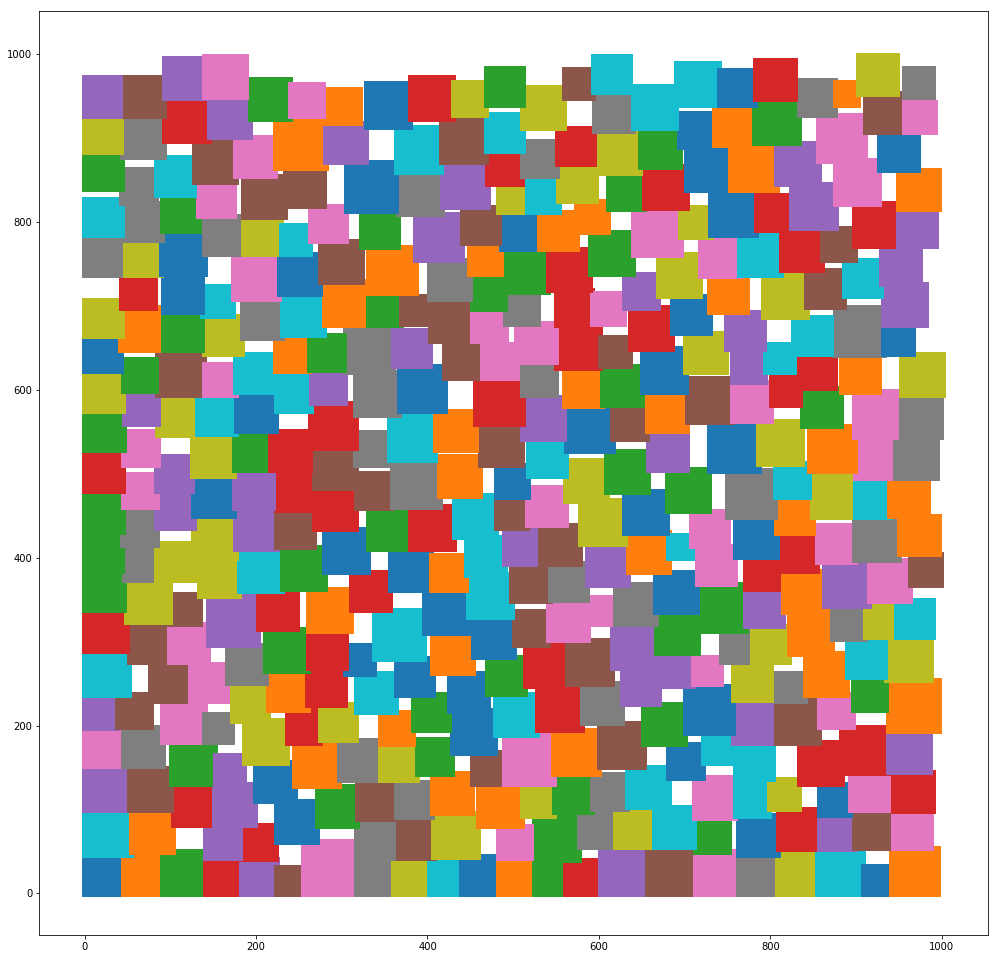

In [50]:
#Draw viz of all lots
fig = plt.figure(figsize = (17,17))
for lot in sim.housing_stock:
    x = [point[0] for point in lot.loc]
    y = [point[1] for point in lot.loc]
    #ADD IF STATEMENT FOR SALE OF LOT
    plt.scatter(x, y, label = lot.size, marker = 's')
plt.show()